## Apple Quality Prediction

In [71]:
# Summary

# Predicting the Quality Label (good/bad) of Apples from Numerical Features (Crunchiness, Acidity, etc.),
# using neural networks and decision trees.

In [1]:
# Data Source: https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality

In [72]:
# Import all the necessary libraries/packages.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Import warnings and set filter warnings to ignore due to the use of deprecated code  
import warnings
warnings.filterwarnings('ignore')

In [73]:
def run_model(classifier, X_train, y_train, X_test, y_test):
    
    # Train the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = classifier.predict(X_test)

    # Evaluate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Display classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Display confusion matrix using a heatmap
    print("Confusion Matrix:")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [74]:
# Read the CSV files into pandas DataFrames and assign them to variables
df = pd.read_csv('apple_quality.csv')

In [75]:
# Display the first few rows of the DataFrame
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good
1,1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good
2,2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad
3,3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good
4,4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good


In [76]:
# Displaying the DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 281.4+ KB


In [77]:
# Drop the column "A_id"
df.drop(columns=["A_id"], inplace=True)

# Convert the "Acidity" column to float type
df["Acidity"] = df["Acidity"].astype("float")

# Map 'good' to 1 and 'bad' to 0 in the "Quality" column
df['Quality'] = df['Quality'].map({'good': 1, 'bad': 0})

# Displaying the modified DataFrame
print(df.head())

       Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity  \
0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840 -0.491590   
1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530 -0.722809   
2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033  2.621636   
3 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761  0.790723   
4  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849  0.501984   

   Quality  
0        1  
1        1  
2        0  
3        1  
4        1  


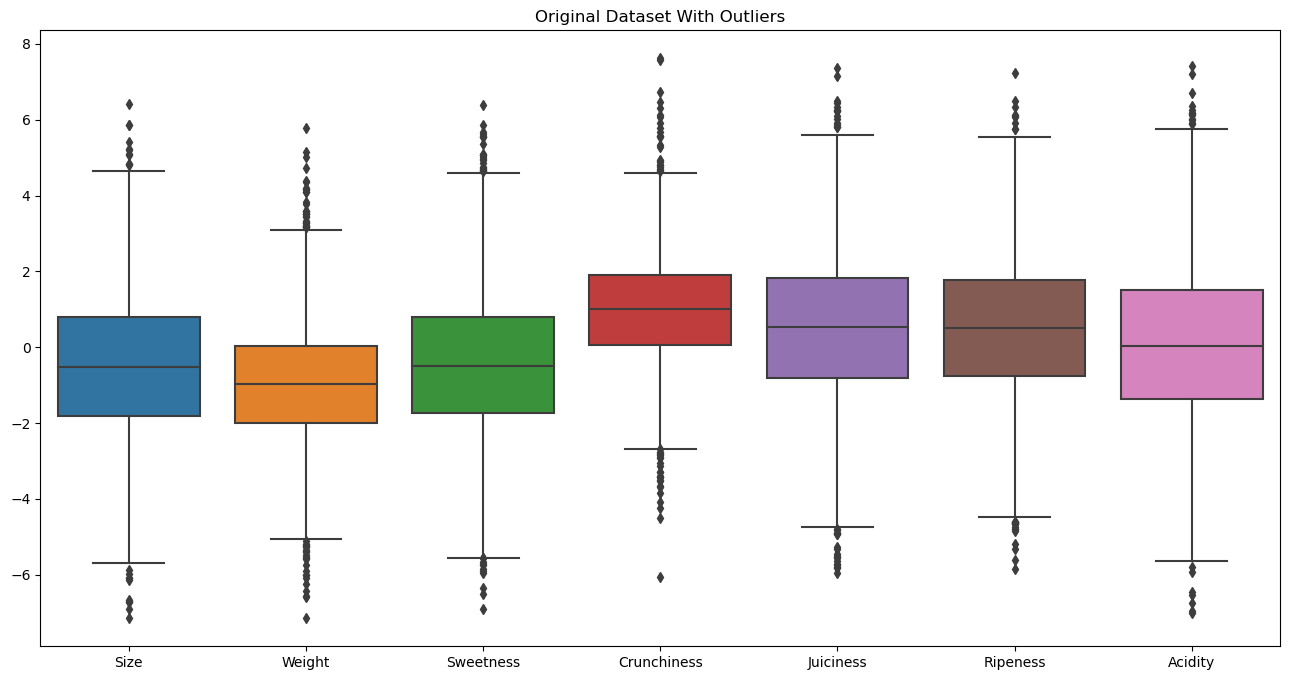

In [78]:
# Create a boxplot
columns_to_plot = df.columns[:7]
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[columns_to_plot])

# Set title and display the plot
plt.title("Original Dataset With Outliers")
plt.show()

In [79]:
# Calculate IQR (Inter-Quartile Range) and identify the outliers
for col in df:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove all values outside of the lower and upper bounds
    clipped_values = np.clip(df[col], lower_bound, upper_bound)

    # Assign the clipped values back to the DataFrame
    df[col] = clipped_values

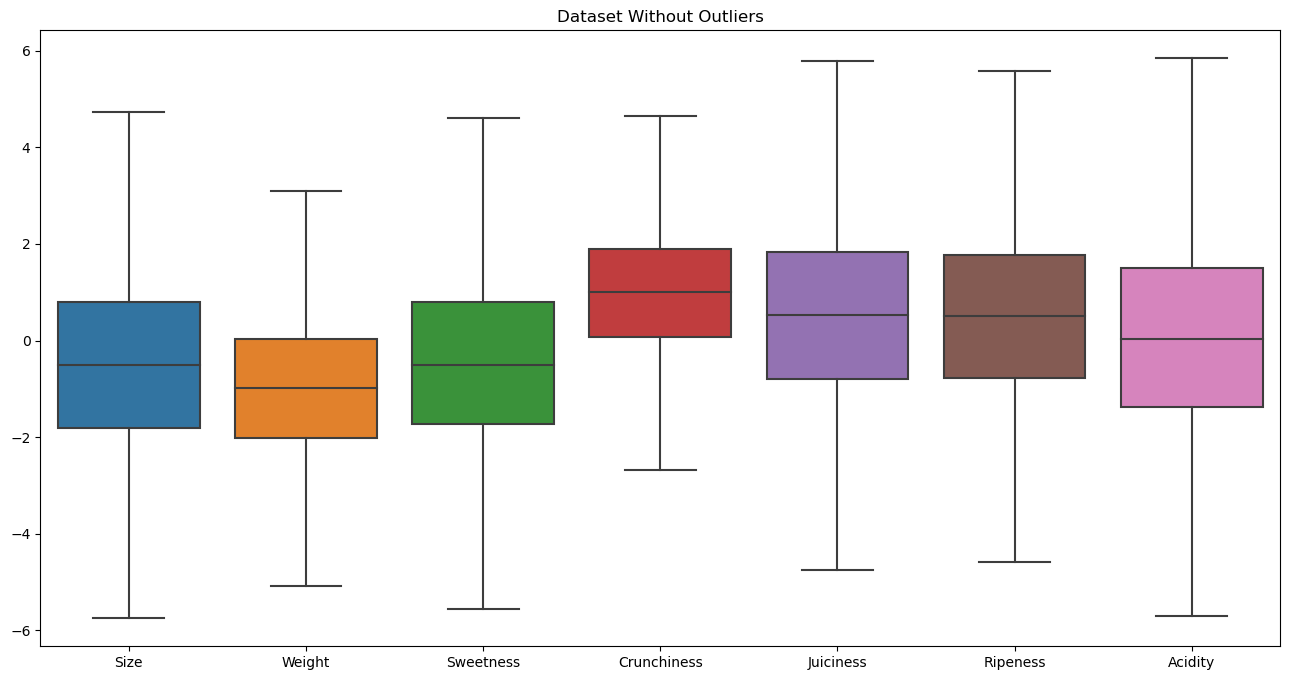

In [80]:
# Create a boxplot
columns_to_plot = df.columns[:7]
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[columns_to_plot])

# Add a title
plt.title("Dataset Without Outliers")

# Show the plot
plt.show()

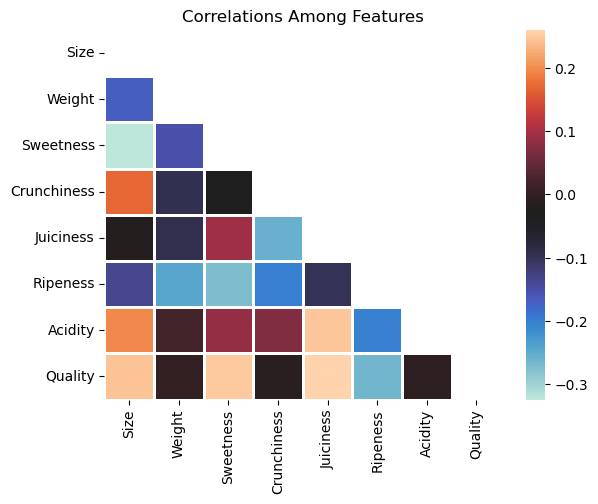

In [81]:
# Determining the best correlation between the chosen indicators

# Create a correlation matrix
correlation_matrix = df.corr()

# Masking all repeated values in the matrix
mask = np.triu(np.ones_like(correlation_matrix))

# Plotting the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, cbar=True, cmap='icefire', fmt=".2f", linewidth=1, mask=mask)

# Add a title to the heatmap
plt.title('Correlations Among Features')

# Show the plot
plt.show()

In [82]:
# Splitting the DataFrame into features (X) and target variable (y)
# X will contain all columns except the "Quality" column
X = df.drop("Quality", axis = 1)

# y will contain only the "Quality" column, serving as the target variable
y = df["Quality"]

In [83]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scaling the features using Min-Max Scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       422
           1       0.89      0.92      0.90       378

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

Confusion Matrix:


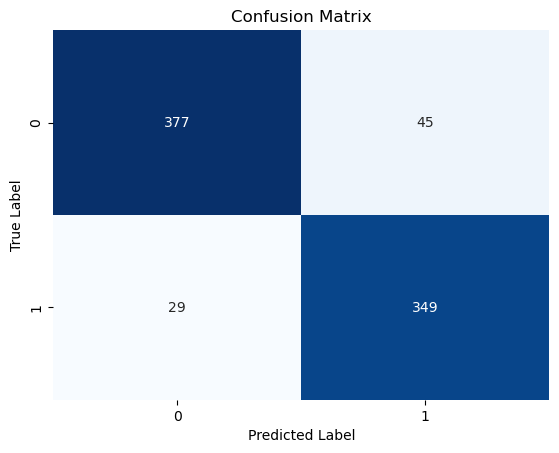

In [84]:
# Multi-level Perceptron Classifier

# Initializing the Multi-Layer Perceptron (MLP) classifier with a random state for reproducibility
classifier = MLPClassifier(random_state=42)

# Fitting the classifier to the training data
classifier.fit(X_train, y_train)

# Running the model evaluation function on both training and testing sets
run_model(classifier, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Number of positive: 1626, number of negative: 1574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508125 -> initscore=0.032503
[LightGBM] [Info] Start training from score 0.032503
Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       422
           1       0.86      0.92      0.89       378

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800

Confusion Matrix:


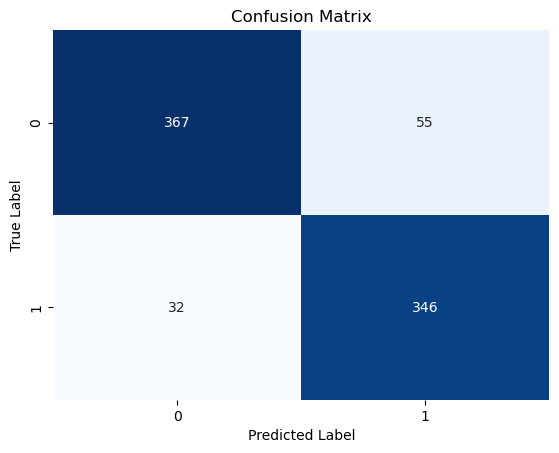

In [85]:
# Light Gradient-Boosting Machine

# Initializing the LightGBM classifier with a random state for reproducibility
classifier = lgb.LGBMClassifier(random_state=42)

# Running the model evaluation function on both training and testing sets
run_model(classifier, X_train, y_train, X_test, y_test)

In [86]:
# Conclusion

# I looked at this dataset,and tried to come up with a way to predict the label (good/bad) of an apple based on
# the numeric attributes of the apple (sweetness, Crunchiness, etc.). After trying these two models - Light Gradient-
# Boosting Machine and Multi-level Perceptron Classifier - and evaluating the accuracy, then conclude that I can use
# the Multi-level Perceptron Classifier to predict the label with a 91% accuracy.